# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [ ]:
!nvidia-smi

Tue Sep 15 01:59:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 56kB/s 


In [2]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [3]:
!pip install tqdm

In [4]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=1d0f1267eaf07540b70a414e8d47ee3a058a3e080fcaed5642419fff0ea09f3f
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=19eaf76a62d8c834f0a7190e96659eb9e45b058bb8489f5ebc7afc6cb4396c8c
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=3d7d55d0ab932f62d09d65a616d2229bd96afed5bf5a092735dbca5981ad876e
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [5]:
!pip install googletrans

     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 962kB 13.4MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=5aa18b1243cd490321d5806b3c9107dec9802b9822ae95ef1e67915ff21cd6a4
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=8badd9ab538f22ca44a3d0bddf2b4691425697afdd00e287659d43defbf760b7
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [6]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 5.4MB/s 


In [7]:
!pip install googletrans

In [8]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [9]:
# English data
!gdown --id 1T46vo1HvVfgT7dVkZwKe3AB9LMjPJ4UD --output data-task2.csv

Downloading...
From: https://drive.google.com/uc?id=1T46vo1HvVfgT7dVkZwKe3AB9LMjPJ4UD
To: /content/data-task2.csv
100% 815k/815k [00:00<00:00, 109MB/s]


In [10]:
df = pd.read_csv('data-task2.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

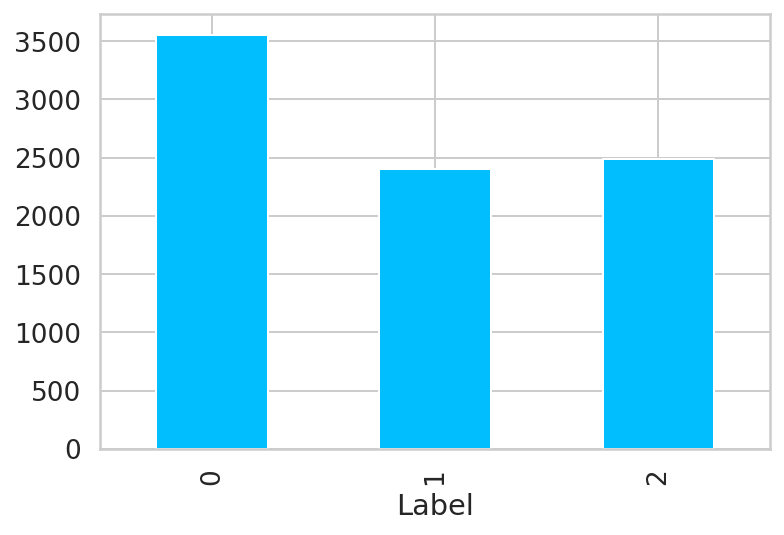

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [12]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

In [14]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'@CuriousPhantomm @TheJaggi He isnâ€™t hindu. ...,0
1,'@dogman_99 CRICKET him and dennis are both la...,0
2,'I have 195 new followers from Pakistan India...,0
3,'Happy Islamic New year #Muharram #NewYear #i...,1
4,'@RyanSidebottom on eggheads.The whole of Hudd...,0
...,...,...
8433,'@chedetofficial Elephant walks DOGs bark. Ke...,2
8434,'Training sessions in Sri Lanka to hold sway i...,0
8435,'@Awan_0786_ You too my dear brotherðŸ’–ðŸ’–,1
8436,'Happy muharram islamic new year #islamicnewyear,1


Data Preprocessing

In [15]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [16]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [17]:
df = df[df.Text != '']

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [19]:
df.head()

,Text,Label
0,CuriousPhantomm TheJaggi He isn t hindu His r...,0
1,dogman 99 CRICKET him and dennis are both lac...,0
2,I have 195 new followers from Pakistan India ...,0
3,Happy Islamic New year Muharram NewYear islam...,1
4,RyanSidebottom on eggheads The whole of Hudde...,0


# Islamophhobia Detection with BERT


In [20]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-15 20:59:28--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   157MB/s    in 2.5s    

2020-09-15 20:59:31 (157 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [21]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [22]:
os.makedirs("model", exist_ok=True)

In [23]:
!mv uncased_L-12_H-768_A-12/ model

In [24]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [25]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [26]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [27]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [28]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7594it [00:02, 2566.66it/s]
844it [00:00, 2495.51it/s]


max seq_len 338


In [29]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa726255a90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [31]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
428/428 [==============================] - 278s 649ms/step - loss: 0.6947 - acc: 0.8560 - val_loss: 0.5969 - val_acc: 0.9500
Epoch 2/5
428/428 [==============================] - 274s 641ms/step - loss: 0.5992 - acc: 0.9532 - val_loss: 0.5905 - val_acc: 0.9592
Epoch 3/5
428/428 [==============================] - 274s 639ms/step - loss: 0.5923 - acc: 0.9596 - val_loss: 0.5842 - val_acc: 0.9671
Epoch 4/5
428/428 [==============================] - 275s 642ms/step - loss: 0.5861 - acc: 0.9641 - val_loss: 0.5862 - val_acc: 0.9658
Epoch 5/5
428/428 [==============================] - 275s 642ms/step - loss: 0.5824 - acc: 0.9688 - val_loss: 0.5919 - val_acc: 0.9592


## Evaluation

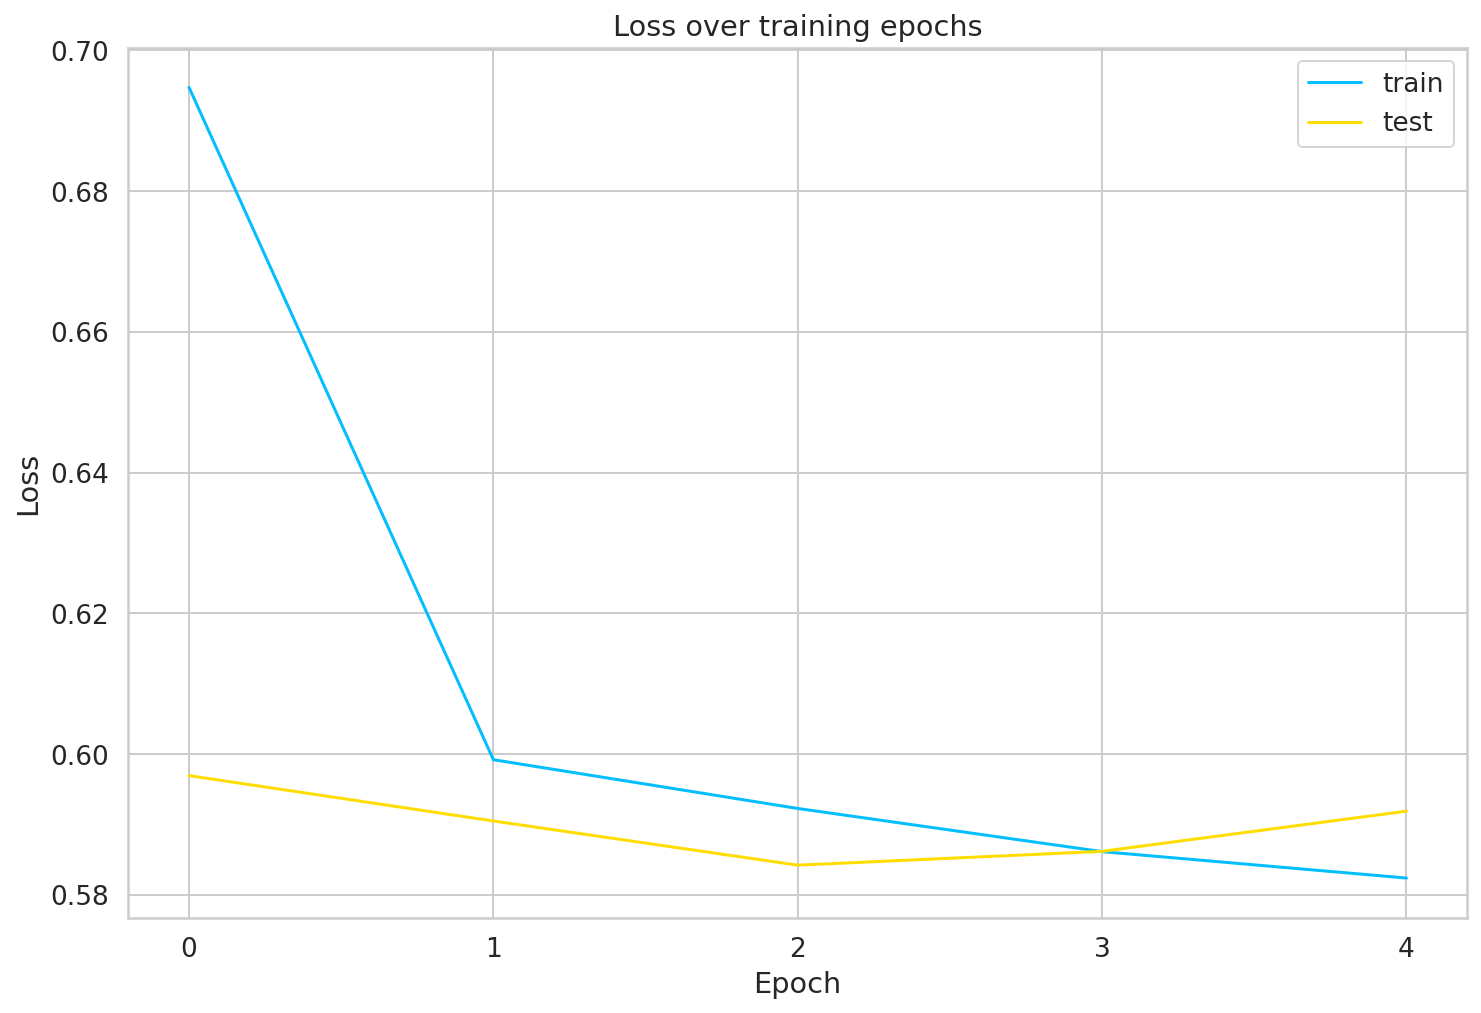

In [32]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

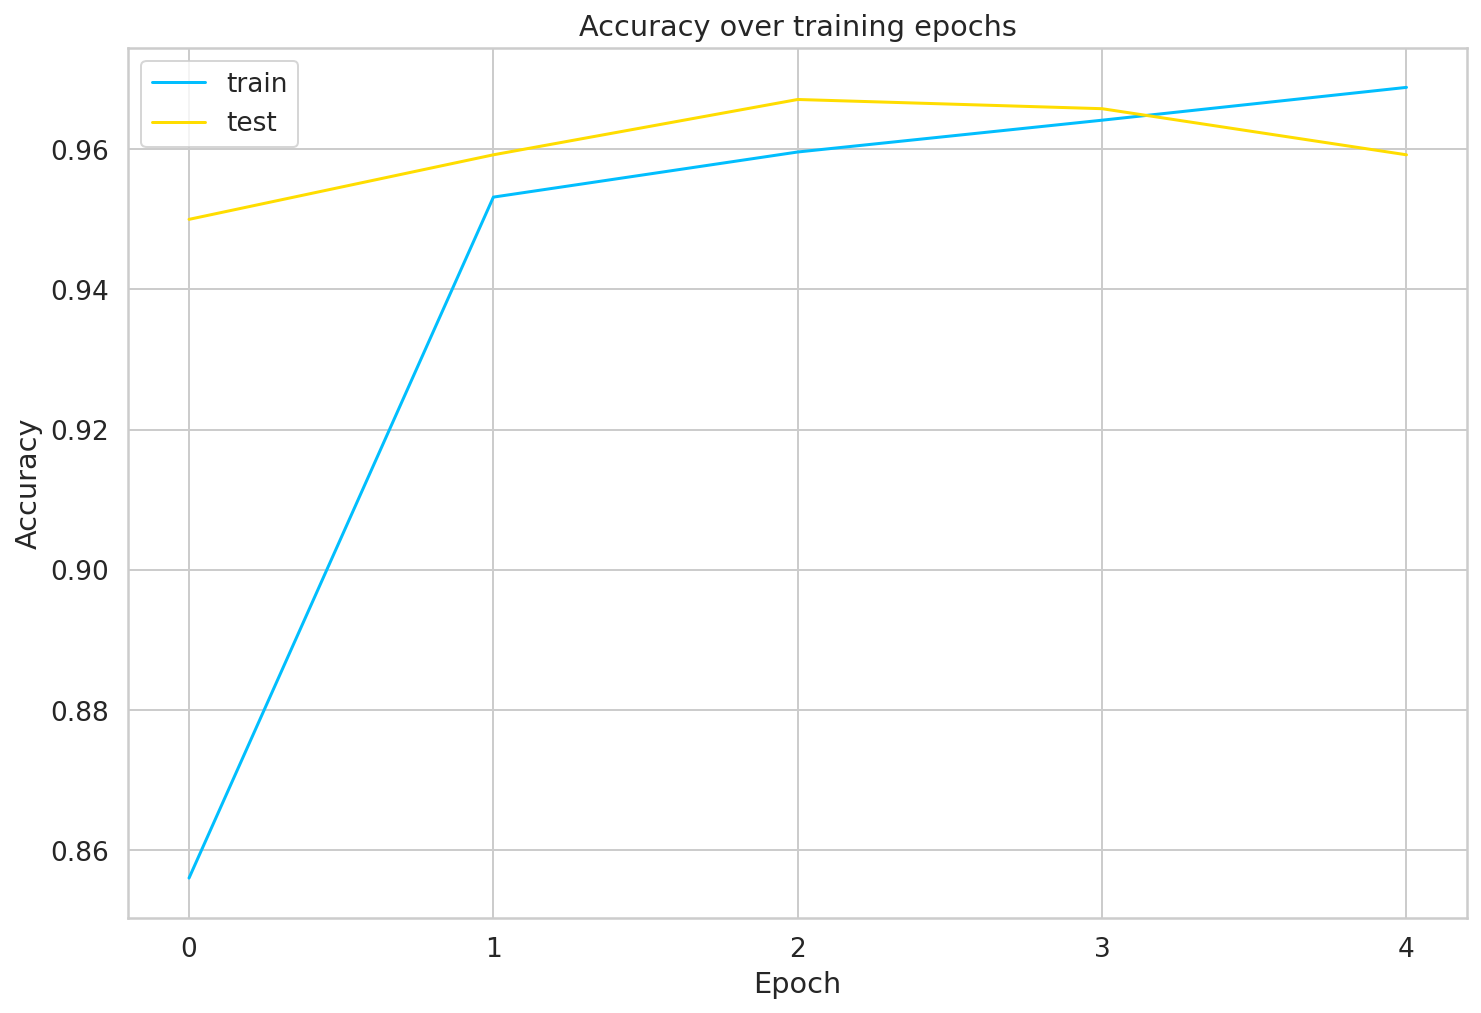

In [33]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [34]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

27/27 [==============================] - 8s 284ms/step - loss: 0.5748 - acc: 0.9751
train acc 0.9724782705307007
test acc 0.9751184582710266


In [35]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [36]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       248
           1       0.99      0.98      0.99       335
           2       0.94      0.99      0.96       261

    accuracy                           0.98       844
   macro avg       0.97      0.97      0.97       844
weighted avg       0.98      0.98      0.98       844



In [37]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

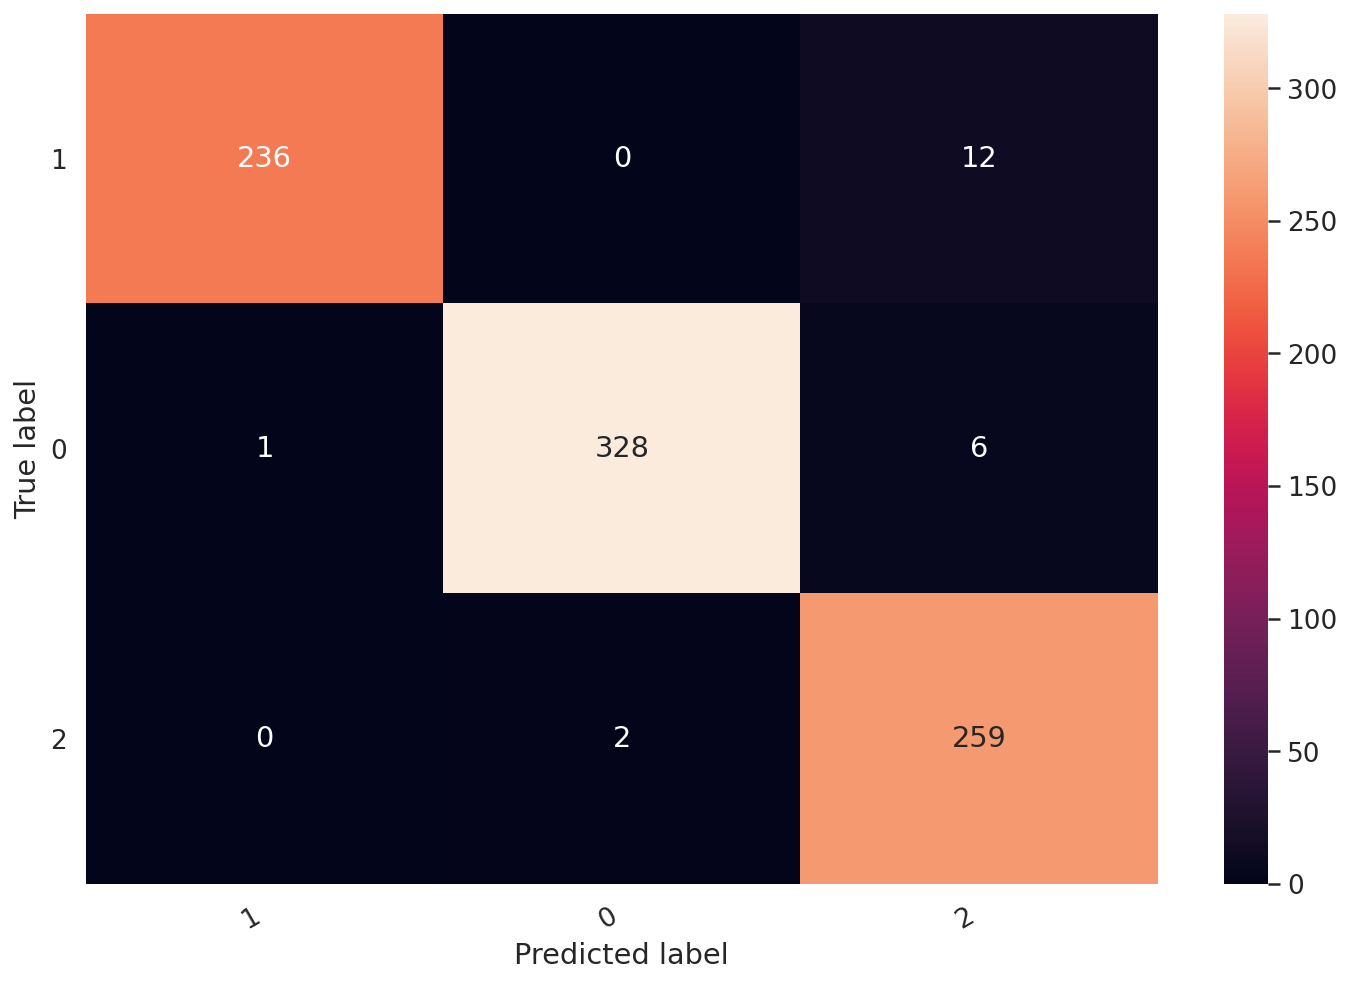

In [38]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [39]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


265it [00:00, 2638.52it/s]

BERT: 
Fold  1



7594it [00:03, 2520.16it/s]
844it [00:00, 2639.95it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa56ea257f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 277s 647ms/step - loss: 0.6964 - acc: 0.8553 - val_loss: 0.6145 - val_acc: 0.9342
Epoch 2/5
428/428 [==============================] - 275s 642ms/step - loss: 0.6000 - acc: 0.9510 - val_loss: 0.5998 - val_acc: 0.9500
Epoch 3/5
428/428 [==============================] - 274s 641ms/step - loss

268it [00:00, 2677.35it/s]

Fold  2



7594it [00:02, 2595.99it/s]
844it [00:00, 2549.81it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5646cf9e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 278s 651ms/step - loss: 0.6952 - acc: 0.8557 - val_loss: 0.6251 - val_acc: 0.9211
Epoch 2/5
428/428 [==============================] - 275s 643ms/step - loss: 0.5994 - acc: 0.9524 - val_loss: 0.6015 - val_acc: 0.9487
Epoch 3/5
428/428 [==============================] - 275s 643ms/step - loss

244it [00:00, 2433.27it/s]

Fold  3



7594it [00:02, 2613.88it/s]
844it [00:00, 2449.58it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa6947adc88> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 280s 655ms/step - loss: 0.7346 - acc: 0.8124 - val_loss: 0.6062 - val_acc: 0.9434
Epoch 2/5
428/428 [==============================] - 277s 647ms/step - loss: 0.5973 - acc: 0.9551 - val_loss: 0.5993 - val_acc: 0.9500
Epoch 3/5
428/428 [==============================] - 277s 648ms/step - loss

264it [00:00, 2634.84it/s]

Fold  4



7594it [00:03, 2526.51it/s]
844it [00:00, 2602.39it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa56faaf3c8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 281s 657ms/step - loss: 0.6839 - acc: 0.8702 - val_loss: 0.6060 - val_acc: 0.9474
Epoch 2/5
428/428 [==============================] - 278s 650ms/step - loss: 0.6008 - acc: 0.9508 - val_loss: 0.6015 - val_acc: 0.9500
Epoch 3/5
428/428 [==============================] - 277s 646ms/step - loss

276it [00:00, 2758.73it/s]

Fold  5



7594it [00:02, 2624.73it/s]
844it [00:00, 2709.94it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa695c4c748> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 277s 648ms/step - loss: 0.8636 - acc: 0.6667 - val_loss: 0.6696 - val_acc: 0.8816
Epoch 2/5
428/428 [==============================] - 275s 642ms/step - loss: 0.6404 - acc: 0.9107 - val_loss: 0.6276 - val_acc: 0.9237
Epoch 3/5
428/428 [==============================] - 275s 643ms/step - loss

261it [00:00, 2607.44it/s]

Fold  6



7594it [00:02, 2668.53it/s]
844it [00:00, 2639.81it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa567a942e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 278s 649ms/step - loss: 0.6832 - acc: 0.8676 - val_loss: 0.6077 - val_acc: 0.9395
Epoch 2/5
428/428 [==============================] - 275s 642ms/step - loss: 0.6043 - acc: 0.9464 - val_loss: 0.5957 - val_acc: 0.9566
Epoch 3/5
428/428 [==============================] - 275s 641ms/step - loss

255it [00:00, 2549.47it/s]

Fold  7



7594it [00:02, 2639.03it/s]
844it [00:00, 2657.44it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa694718ba8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 276s 645ms/step - loss: 0.7519 - acc: 0.7893 - val_loss: 0.6161 - val_acc: 0.9355
Epoch 2/5
428/428 [==============================] - 273s 638ms/step - loss: 0.6059 - acc: 0.9448 - val_loss: 0.6131 - val_acc: 0.9368
Epoch 3/5
428/428 [==============================] - 274s 640ms/step - loss

246it [00:00, 2453.82it/s]

Fold  8



7594it [00:02, 2652.93it/s]
844it [00:00, 2798.38it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5670a4da0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 278s 651ms/step - loss: 0.6887 - acc: 0.8611 - val_loss: 0.6030 - val_acc: 0.9474
Epoch 2/5
428/428 [==============================] - 276s 645ms/step - loss: 0.6016 - acc: 0.9495 - val_loss: 0.6028 - val_acc: 0.9474
Epoch 3/5
428/428 [==============================] - 276s 646ms/step - loss

272it [00:00, 2710.74it/s]

Fold  9



7594it [00:02, 2643.75it/s]
844it [00:00, 2808.45it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa461bc64a8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 279s 652ms/step - loss: 0.6816 - acc: 0.8733 - val_loss: 0.6002 - val_acc: 0.9474
Epoch 2/5
428/428 [==============================] - 277s 646ms/step - loss: 0.5986 - acc: 0.9542 - val_loss: 0.6069 - val_acc: 0.9434
Epoch 3/5
428/428 [==============================] - 276s 645ms/step - loss

269it [00:00, 2680.00it/s]

Fold  10



7594it [00:02, 2654.07it/s]
844it [00:00, 2762.06it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa5680d0f98> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
428/428 [==============================] - 279s 653ms/step - loss: 0.7463 - acc: 0.7938 - val_loss: 0.6007 - val_acc: 0.9526
Epoch 2/5
428/428 [==============================] - 277s 648ms/step - loss: 0.6027 - acc: 0.9488 - val_loss: 0.5941 - val_acc: 0.9566
Epoch 3/5
428/428 [==============================] - 277s 646ms/step - loss

In [40]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9592417061611374
 Mean testing accuracy for 10 folds: 0.9592417061328888


In [41]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful
Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 0

